## Results of Host Prediction
### Dataset: Coronaviridae S prot UniRef90, EMBL mapping, Vertebrates

**Models**: TF - Pretrain  + finetune

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**: 1336

**Alignment**: Yes, No

**Classification**: Multi-class

**\# classes**: 8, 2

**\# train samples** = 

**\# validation samples** = 

**\# test samples** = 


In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/miniconda3/envs/zoonosis/lib/python311.zip',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/lib-dynload',
 '',
 '/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/coronaviridae/../..']

In [2]:
#! pip install --upgrade seaborn

In [3]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from src.utils import utils, evaluation_utils, visualization_utils
from sklearn.metrics import auc, precision_recall_curve
from statistics import mean

In [4]:
sns.__version__

'0.13.0'

In [44]:
itr_col = "itr"
experiment_col = "experiment"
y_true_col = "y_true"
human_col = "Human"
auprcs_df = None
def class_wise_auprc_analysis(output_filepaths, classes, figure_output_filepath=None):
    auprc_results = []
    classes = None
    for model, output_filepath in output_filepaths.items():
        df = pd.read_csv(output_filepath, index_col=0)
        print(f"Read output {model} = {df.shape}")
        
        cols = df.columns
        classes = list(set(cols) - set([itr_col, experiment_col, y_true_col]))
        itrs = df[itr_col].unique()
    
        for itr in itrs:
            df_itr = df[df[itr_col] == itr]
            _, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=classes, y_true_col=y_true_col)
            auprcs_df = pd.concat([auprcs_df, 
                                   pd.DataFrame({"class": ["Macro-AUPRC"], "auprc": [auprcs_df["auprc"].mean()]})
                                  ], ignore_index=True)
            auprcs_df["model"] = model
            auprcs_df["itr"] = itr
            auprc_results.append(auprcs_df)
    metadata = utils.compute_class_distribution(df_itr, y_true_col, format=False)
    metadata_formatted = utils.compute_class_distribution(df_itr, y_true_col, format=True)
    metadata_sorted = {}
    for k, v in metadata.items():
        metadata_sorted[metadata_formatted[k]] = v
    #metadata_sorted["Macro-AUPRC"] = 0
    auprc_results_df = pd.concat(auprc_results, ignore_index=True)
    auprc_results_df.replace({"class": metadata_formatted}, inplace=True)
    

    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16
    plt.rcParams.update({'font.size': 16})
    fig, axs = plt.subplots(1, 2, figsize=(14, 7), sharex=False, sharey=True, gridspec_kw={"width_ratios": [1, 4]})
    color_palette = sns.cubehelix_palette(start=1, rot=-.9, hue=1, dark=.35, light=.85, n_colors=auprc_results_df["model"].nunique())
    color_palette_green = sns.cubehelix_palette(start=2, light=0.8, rot=1, dark=.9, n_colors=auprc_results_df["model"].nunique())

    print(auprc_results_df[auprc_results_df["class"].isin(metadata_formatted.values())].shape)
    print(auprc_results_df[auprc_results_df["class"] == "Macro-AUPRC"].shape)
    sns.barplot(data=auprc_results_df[auprc_results_df["class"] == "Macro-AUPRC"], x="class", y="auprc", hue="model", fill=True,
                orient="v", palette=color_palette, ax=axs[0],
                 errorbar=None, linewidth=1, edgecolor="0", legend=False)
#     sns.violinplot(data=auprc_results_df[auprc_results_df["class"] == "Macro-AUPRC"], x="class", y="auprc", hue="model", fill=True,
#                 orient="v", palette=color_palette, legend=False, ax=axs[0])
    for i in axs[0].containers:
        axs[0].bar_label(i, fontsize=12, fmt="%.2f")
    sns.barplot(data=auprc_results_df[auprc_results_df["class"].isin(metadata_formatted.values())], x="class", y="auprc", hue="model", orient="v", order=metadata_sorted, palette=color_palette, ax=axs[1])
    #sns.violinplot(data=auprc_results_df[auprc_results_df["class"].isin(metadata_formatted.values())], x="class", y="auprc", hue="model", orient="v", order=metadata_sorted, palette=color_palette, ax=axs[1], legend="auto")
    plt.draw()
    
    axs[0].set_ylim(0.0, 1)
    axs[1].set_ylim(0.2, 1)
    axs[0].set_ylabel("AUPRC", size=16)
    axs[0].set_xlabel("", size=0, labelpad=0)
    axs[1].set_xlabel("", size=0, labelpad=0)
    sns.move_legend(axs[1], "lower center", bbox_to_anchor=(.36, 1), ncol=5, title=None, frameon=False)
    plt.setp(axs[1].get_legend().get_texts(), fontsize=16)
    visualization_utils.wrap_ticklabels(axs[0], axis="x")
    visualization_utils.wrap_ticklabels(axs[1], axis="x")
    
    plt.subplots_adjust(wspace=0.004)
    plt.savefig(figure_output_filepath)
    plt.show()
    return auprc_results_df

### UniRef90

In [45]:

file_paths = {
    #"ProteinBERT": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240902/host_multi/proteinbert/uniref90_cov_s_prot_embl_hosts/finetune_prediction_results_20240902_222843.csv"),
    "ProtT5": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20250131/host_multi/external/uniref90coronaviridae_prot_t5_xl_uniref50_fnn_2l_d1024_lr3e-4_output.csv"),
    "ProstT5": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20250131/host_multi/external/uniref90coronaviridae_prostt5_fnn_2l_d1024_lr3e-4_output.csv"),
    #"ESM2-35M": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20241216/host_multi/external/uniref90coronaviridae_esm2_t12_35M_UR50D_bn_fnn_2l_d1024_lr1e-4_output.csv"),
    #"ESM2-650M": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20241118/host_multi/external/uniref90coronaviridae_esm2_msl2048_bn_fnn_2l_d1024_lr1e-4_output.csv"),
    #"ESM2-3B": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20241204/host_multi/external/uniref90coronaviridae_esm2_t36_3B_UR50D_bn_fnn_2l_d1024_lr1e-4_output.csv"),
    "ESM3": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20241204/host_multi/external/uniref90coronaviridae_esm3_bn_fnn_2l_d1024_lr1e-4_output.csv"),
    #"ProteinBERT-2048": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240902/host_multi/proteinbert/uniref90_cov_s_prot_embl_hosts/finetune_prediction_results_20240903_140312.csv"),
    #"VirProBERT-1366": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240320/fine_tuning/host_prediction/multi/mlm_tfenc_l6_h8_lr1e-4_uniref90_coronaviridae_s_msl1366_host_prediction_fnn_2l_d1024_lr1e-4_output.csv"),
    #"Hybrid-sl256st64": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240828/host_multi/fine_tuning_hybrid/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b512_ae_bn_vs30_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
    #"Hybrid-sl256st64-CLS": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240828/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b512_ae_bn_vs30cls_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
    "VirProBERT": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240828/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b512_ae_bn_vs30cls_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
#     "VirProBERT1e-4": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240828/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b512_ae_bn_vs30cls_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
#     "VirProBERT1e-5": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20240909/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_vs30_hybrid_attention_msl256s64ae_bn_cls_fnn_2l_d1024_lr1e-5_output.csv"),
#     "VirProBERT3e-4": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniref90_embl_vertebrates_t0.01_c8/20241117/host_multi/virprobert/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_vs30_hybrid_attention_msl256s64ae_bn_cls_fnn_2l_d1024_lr3e-4_output.csv"),
}

classes = ["Chicken", "Human", "Cat", "Pig", "Gray wolf", "Horshoe bat", "Ferret", "Chinese rufous horseshoe bat"]

Read output ProtT5 = (345, 10)
Read output ProstT5 = (345, 10)
Read output ESM3 = (345, 10)
Read output VirProBERT = (345, 10)
(160, 4)
(20, 4)


/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

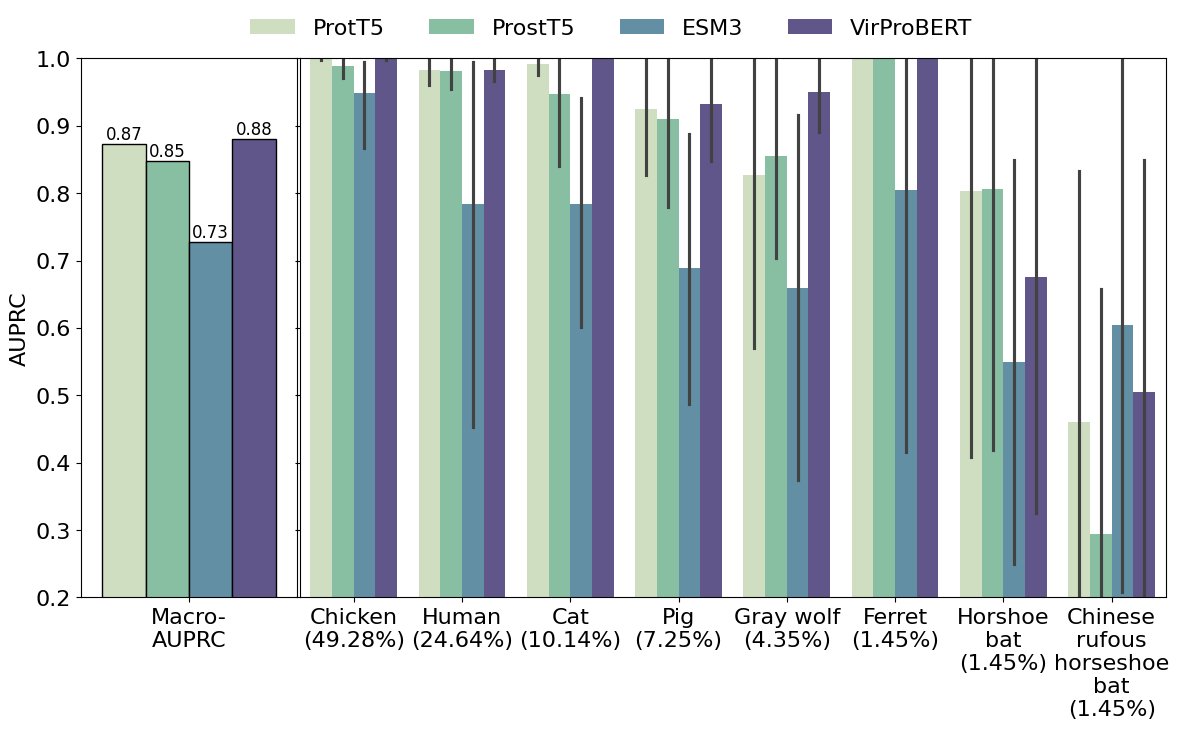

,class,auprc,model,itr
0,Chicken (49.28%),1.000000,ProtT5,0
1,Gray wolf (4.35%),0.358192,ProtT5,0
2,Pig (7.25%),0.885455,ProtT5,0
3,Horshoe bat (1.45%),1.000000,ProtT5,0
4,Chinese rufous horseshoe bat (1.45%),1.000000,ProtT5,0
...,...,...,...,...
175,Chinese rufous horseshoe bat (1.45%),1.000000,VirProBERT,4
176,Human (24.64%),1.000000,VirProBERT,4
177,Cat (10.14%),1.000000,VirProBERT,4
178,Ferret (1.45%),1.000000,VirProBERT,4


In [46]:
class_wise_auprc_analysis(file_paths, classes,
                         figure_output_filepath=os.path.join(os.getcwd(), "..", "..", "..", "..", f"output/visualization/temp_new/host_multi_cov_s_uniref90_auprc_barplot.png"))


### UniProt

In [30]:
file_paths = {
    #"ProteinBERT": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240902/host_multi/proteinbert/uniprot_cov_s_prot_embl_hosts/finetune_prediction_results_20240902_224530.csv"),
    "ProtT5": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20250131/host_multi/external/uniprot_coronaviridae_prot_t5_xl_uniref50_fnn_2l_d1024_lr3e-4_output.csv"),
    "ProstT5": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20250131/host_multi/external/uniprot_coronaviridae_prostt5_fnn_2l_d1024_lr3e-4_output.csv"),
    
    #"ProteinBERT-2048": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240902/host_multi/proteinbert/uniprot_cov_s_prot_embl_hosts/finetune_prediction_results_20240903_132840.csv"),
    #"VirProBERT-1366": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240326/fine_tuning/host_prediction/multi/mlm_tfenc_l6_h8_lr1e-4_uniprot_coronaviridae_s_msl1366_host_prediction_fnn_2l_d1024_lr1e-4_output.csv"),
    #"Hybrid-sl256st64": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240828/host_multi/fine_tuning_hybrid/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b512_ae_bn_vs30_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
    #"Hybrid-sl256st64-CLS": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240828/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b512_ae_bn_vs30cls_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
    #"ESM2-35M": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20241216/host_multi/external/uniprot_coronaviridae_esm2_t12_35M_UR50D_bn_fnn_2l_d1024_lr1e-4_output.csv"),
    #"ESM2-650M": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20241118/host_multi/external/uniprot_coronaviridae_esm2_msl2048_bn_fnn_2l_d1024_lr1e-4_output.csv"),
    "ESM2-3B": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20241204/host_multi/external/uniprot_coronaviridae_esm2_t36_3B_UR50D_bn_fnn_2l_d1024_lr1e-4_output.csv"),
    "ESM3": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20241204/host_multi/external/uniprot_coronaviridae_esm3_bn_fnn_2l_d1024_lr1e-4_output.csv"),
    "VirProBERT": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240828/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b512_ae_bn_vs30cls_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
#     "VirProBERT1e-4": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240828/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl256b512_ae_bn_vs30cls_s64_hybrid_attention_s64_fnn_2l_d1024_lr1e-4_output.csv"),
#     "VirProBERT1e-5": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20240909/host_multi/fine_tuning_hybrid_cls/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_vs30_hybrid_attention_msl256s64ae_bn_cls_fnn_2l_d1024_lr1e-5_output.csv"),
#     "VirProBERT3e-4": os.path.join(os.getcwd(), "..","..", "..", "..", "output/raw/coronaviridae_s_prot_uniprot_embl_vertebrates_t0.01_c8/20241117/host_multi/virprobert/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_vs30_hybrid_attention_msl256s64ae_bn_cls_fnn_2l_d1024_lr3e-4_output.csv"),
    
}


classes = ["Pig", "Human", "Cat", "Dromedary camel", "Cattle", "Chicken", "Gray wolf", "Yak"]

Read output ProtT5 = (345, 10)
Read output ProstT5 = (345, 10)
Read output ESM3 = (345, 10)
Read output VirProBERT = (345, 10)
(160, 4)
(20, 4)


/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

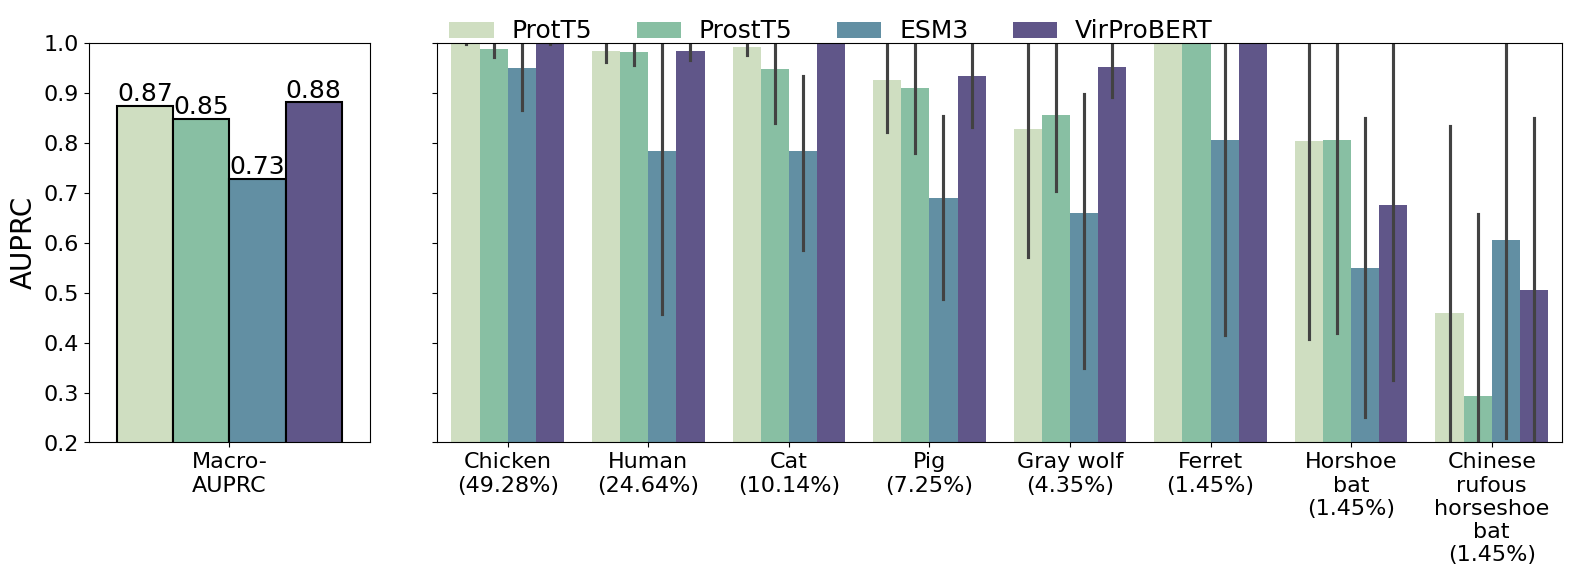

,class,auprc,model,itr
0,Chinese rufous horseshoe bat (1.45%),1.000000,ProtT5,0
1,Ferret (1.45%),1.000000,ProtT5,0
2,Cat (10.14%),1.000000,ProtT5,0
3,Horshoe bat (1.45%),1.000000,ProtT5,0
4,Human (24.64%),0.988515,ProtT5,0
...,...,...,...,...
175,Human (24.64%),1.000000,VirProBERT,4
176,Chicken (49.28%),1.000000,VirProBERT,4
177,Pig (7.25%),1.000000,VirProBERT,4
178,Gray wolf (4.35%),1.000000,VirProBERT,4


In [37]:
class_wise_auprc_analysis(file_paths, classes, 
                          figure_output_filepath=os.path.join(os.getcwd(), "..", "..", "..", "..", f"output/visualization/temp_new/host_multi_cov_s_uniprot_auprc_barplot.pdf"))